--------------------------------------------------
Tìm thấy 5 Mã Sản Phẩm: ['Product_0993' 'Product_0979' 'Product_1159' 'Product_1938'
 'Product_1157']
--------------------------------------------------
Đang hiển thị biểu đồ Histogram kết hợp (So sánh Phân phối)...


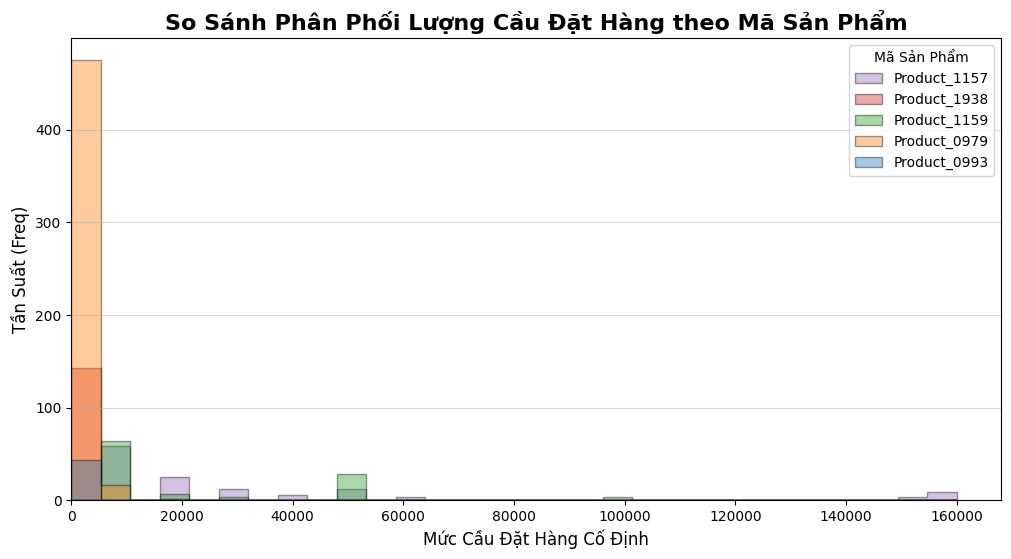

--------------------------------------------------
Bảng Tóm Tắt Thống Kê Quan Trọng cho Từng Sản Phẩm:
(CV2 và Skewness giúp xác định liệu có cần biến đổi Log/Sqrt cho Hồi quy không)
   Product_Code  Count      Mean    StdDev    Min     Max  \
0  Product_0979    492    938.62   2070.23      0   20000   
1  Product_0993     43    144.19     85.36    100     500   
2  Product_1157    131  34885.50  43116.42  10000  160000   
3  Product_1159    105  24476.19  21705.23  10000  100000   
4  Product_1938    143      3.40      3.12      1      10   

   CV2 (StdDev^2/Mean)  Skewness  
0              4566.12      4.49  
1                50.54      2.36  
2             53289.35      2.23  
3             19247.98      1.50  
4                 2.86      1.28  


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Đọc file Excel gốc
df = pd.read_excel(r"data/datasetprj_2012_cleaned.xlsx")

# Làm sạch dữ liệu Order_Demand
df['Order_Demand'] = pd.to_numeric(df['Order_Demand'], errors='coerce')
df.dropna(subset=['Order_Demand'], inplace=True)
df['Order_Demand'] = df['Order_Demand'].astype(int)

# Xác định các Mã Sản Phẩm (Product_Code) duy nhất và Chuẩn bị Dữ liệu
product_codes = df['Product_Code'].unique()
num_products = len(product_codes)
print("-" * 50)
print(f"Tìm thấy {num_products} Mã Sản Phẩm: {product_codes}")

# Tạo danh sách dữ liệu để truyền vào hàm plt.hist (mỗi phần tử là Series Order_Demand của một sản phẩm)
demand_list = [df[df['Product_Code'] == code]['Order_Demand'] for code in product_codes]

# Tính toán số BINS chung cho tất cả sản phẩm
# SỬA LỖI: Sử dụng phương pháp BINS dựa trên căn bậc hai (Sturges) để tạo Bins rõ ràng hơn.
# Sau đó tính toán các điểm biên của BINS (bin edges) để đảm bảo tất cả sản phẩm dùng chung
max_demand = df['Order_Demand'].max()
min_demand = df['Order_Demand'].min()

# Tính số lượng BINS tối ưu (ví dụ: tối đa 50 bins)
optimal_bins = int(np.sqrt(len(df)))
bins_count = min(optimal_bins, 50)

# Tạo các điểm biên BINS (bin edges)
bins_common = np.linspace(min_demand, max_demand, bins_count + 1)


# Vẽ Histogram Kết hợp
plt.figure(figsize=(12, 6))

# Vẽ histogram
# histtype='step' sẽ chỉ vẽ đường viền thanh, giúp thấy rõ sự chồng chéo hơn
plt.hist(demand_list, 
         bins=bins_common,
         label=product_codes,
         alpha=0.4, # Giảm alpha để thấy rõ hơn khi chồng chéo
         edgecolor='black', # Thêm đường viền đen
         stacked=False, # stacked=False để chồng chéo (overlapping) chứ không phải xếp chồng (stacking)
         histtype='stepfilled' # histtype='stepfilled' cho thanh đầy màu
        )

# 6️⃣ Tinh chỉnh tổng thể và hiển thị
plt.title('So Sánh Phân Phối Lượng Cầu Đặt Hàng theo Mã Sản Phẩm', fontsize=16, fontweight='bold')
plt.xlabel('Mức Cầu Đặt Hàng Cố Định', fontsize=12)
plt.ylabel('Tần Suất (Freq)', fontsize=12)
plt.legend(title='Mã Sản Phẩm', fontsize=10)
plt.grid(axis='y', alpha=0.5)

# Bổ sung lệnh cố định trục X để loại bỏ vùng 'âm' không cần thiết
plt.xlim(xmin=0, xmax=max_demand * 1.05) # Giới hạn trục X đến giá trị cầu lớn nhất

print("-" * 50)
print("Đang hiển thị biểu đồ Histogram kết hợp (So sánh Phân phối)...")
plt.show()

# ============================# PHÂN TÍCH THỐNG KÊ RỦI RO (Cho Hồi quy)# ============================

# Tính toán các chỉ số thống kê quan trọng cho mỗi sản phẩm
stats_df = df.groupby('Product_Code')['Order_Demand'].agg([
    'count', 
    'mean', 
    'std', 
    'min', 
    'max', 
    lambda x: x.var() / x.mean(), # Hệ số Biến thiên Bình phương (CV2): Chỉ số quan trọng trong tồn kho
    lambda x: x.skew() # Độ lệch (Skewness): Kiểm tra tính đối xứng của phân phối
]).reset_index()

# Đổi tên cột cho dễ đọc
stats_df.columns = ['Product_Code', 'Count', 'Mean', 'StdDev', 'Min', 'Max', 'CV2 (StdDev^2/Mean)', 'Skewness']

print("-" * 50)
print("Bảng Tóm Tắt Thống Kê Quan Trọng cho Từng Sản Phẩm:")
print("(CV2 và Skewness giúp xác định liệu có cần biến đổi Log/Sqrt cho Hồi quy không)")
print(stats_df.round(2))


## 1. Phân Phối Chung và Tính Chất Rời Rạc
# Biểu đồ histogram chồng cho thấy phân phối của biến Order_Demand trong năm 2012 mang hai đặc điểm nổi bật:
# Lệch phải mạnh (Strongly Right-Skewed): Tần suất xuất hiện tập trung chủ yếu tại các mức cầu thấp, 
# trong khi các giá trị cầu cao xuất hiện rất hiếm, tạo nên “đuôi phải” dài. 
# Điều này phản ánh rằng phần lớn đơn hàng có quy mô nhỏ, còn các đơn hàng lớn chỉ chiếm tỷ lệ rất nhỏ.

# Tính rời rạc (Discrete Nature): Dữ liệu không liên tục mà tập trung tại các mức cầu cố định 
# (100, 500, 1000). Đặc tính này gợi ý rằng doanh nghiệp vận hành theo cơ chế đặt hàng theo lô hoặc đơn vị đóng gói tiêu chuẩn.

# mỗi sản phẩm có hồ sơ cầu và mức độ biến động riêng biệt, với một số sản phẩm chiếm ưu thế ở vùng cầu thấp (thể hiện tần suất giao dịch cao) 
# trong khi các sản phẩm khác có giá trị kéo dài về phía phải (cho thấy phương sai lớn và sự hiện diện của các giá trị ngoại lệ). 
# Những khác biệt này chứng minh rằng biến Product_Code có ảnh hưởng đáng kể và cần được xem xét như một biến độc lập trong mô hình hồi quy. 
# Từ góc độ mô hình hóa, phân phối lệch phải mạnh của Order_Demand có thể vi phạm giả định chuẩn của phần dư, do đó cần áp dụng các phép chuyển đổi 
# logarit hoặc căn bậc hai để chuẩn hóa biến phụ thuộc. Đồng thời, sự khác biệt giữa các mã sản phẩm yêu cầu phải mã hóa biến định tính dưới dạng 
# biến giả (one-hot encoding) nhằm đảm bảo mô hình phản ánh chính xác tác động riêng của từng sản phẩm. Ngoài ra, các giá trị cực đại trong “đuôi phải” 
# cần được kiểm tra và xử lý thích hợp để tránh ảnh hưởng không cân xứng đến kết quả hồi quy. Việc sử dụng histogram chồng màu là bước trực quan hóa 
# phù hợp để nhận diện xu hướng tổng thể và khác biệt giữa các nhóm sản phẩm, song để phân tích chi tiết hơn về phương sai và giá trị ngoại lệ, 
# nên bổ sung thêm các biểu đồ boxplot hoặc violin plot trong giai đoạn tiếp theo.
